## Summary

----

## Imports

In [1]:
import json
import os
import os.path as op
import shlex
import shutil
import subprocess
import sys
import tempfile
import time
import xml.etree.ElementTree as ET
from pathlib import Path
from textwrap import dedent

import kmtools.sci_tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proteinsolver
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch_geometric
from IPython.display import HTML, SVG, display
from kmbio import PDB
from kmtools import structure_tools
from matplotlib.ticker import FuncFormatter
from scipy import stats
from torch_geometric.data import Batch
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed for pdf2svg
PYTHON_PATH = op.dirname(sys.executable)

if PYTHON_PATH not in os.environ["PATH"]:
    os.environ["PATH"] = f'{PYTHON_PATH}:{os.environ["PATH"]}'

## Properties

In [4]:
NOTEBOOK_NAME = "11_analyze_generated_sequences"

In [5]:
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/11_analyze_generated_sequences')

In [6]:
UNIQUE_ID = "191f05de"

In [7]:
DESIGNS_PATH = NOTEBOOK_PATH.parent.joinpath("generate_protein_sequences")
assert DESIGNS_PATH.is_dir()

DESIGNS_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences')

In [8]:
SEQUENCE_GENERATION_METHOD = "expectimax"

assert SEQUENCE_GENERATION_METHOD in ("astar", "randexpectimax", "expectimax", "logexpectimax", "root2expectimax", "root10expectimax")

In [9]:
# STRUCTURE_ID = "1n5uA03"  # poster
# STRUCTURE_ID = "4z8jA00"
# STRUCTURE_ID = "4unuA00"
STRUCTURE_ID = "4beuA02"  # poster

STRUCTURE_ID

'4beuA02'

In [10]:
STRUCTURE_FILE = Path(proteinsolver.__path__[0]).joinpath("data", "inputs", f"{STRUCTURE_ID}.pdb")
assert STRUCTURE_FILE.is_file()

STRUCTURE_FILE

PosixPath('/home/strokach/conda/envs/default/lib/python3.7/site-packages/proteinsolver/data/inputs/4beuA02.pdb')

In [11]:
with DESIGNS_PATH.joinpath(f"stats-{UNIQUE_ID}-{STRUCTURE_FILE.stem}.json").open("rt") as fin:
    model_stats = json.load(fin)

model_stats

{'map_sequence_identity': 0.41013824884792627,
 'map_proba': 0.5304911136627197,
 'map_logproba': -0.6995142102241516,
 'ref_sequence_identity': 1.0,
 'ref_proba': 0.3164460062980652,
 'ref_logproba': -1.7113533020019531}

## Load structure

In [12]:
structure_all = PDB.load(STRUCTURE_FILE)
structure = PDB.Structure(STRUCTURE_FILE.name + "A", structure_all[0].extract('A'))
assert len(list(structure.chains)) == 1

In [13]:
view = PDB.view_structure(structure)

view

_ColormakerRegistry()

NGLWidget()

## Design pipeline

### Load protein sequence and geometry

In [14]:
structure = PDB.load(STRUCTURE_FILE)
pdata = proteinsolver.utils.extract_seq_and_adj(structure, 'A')
print(pdata)

ProteinData(sequence='LGQFQSNIEQFKSHMNANTKICAIMKADAYGNGIRGLMPTIIAQGIPCVGVASNAEARAVRESGFKGELIRVRSASLSEMSSALDLNIEELIGTHQQALDLAELAKQSGKTLKVHIALNDGGMGRNGIDMTTEAGKKEAVSIATQPSLSVVGIMTHFPNYNADEVRAKLAQFKESSTWLMQQANLKREEITLHVANSYTALNVPEAQLDMVRPGGVL', row_index=array([  0,   0,   0, ..., 214, 214, 215]), col_index=array([  1,   2,   3, ..., 215, 216, 216]), distances=array([1.32022915, 3.15466353, 2.63357893, ..., 1.32993534, 3.03500198,
       1.33465127]))


In [15]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
print(data.edge_attr.min())
data = proteinsolver.datasets.protein.transform_edge_attr(data)
print(data.edge_attr.min())

tensor(1.3150)
tensor(-3.1703)


In [16]:
sequence_ref = pdata.sequence
print(len(sequence_ref), sequence_ref)

217 LGQFQSNIEQFKSHMNANTKICAIMKADAYGNGIRGLMPTIIAQGIPCVGVASNAEARAVRESGFKGELIRVRSASLSEMSSALDLNIEELIGTHQQALDLAELAKQSGKTLKVHIALNDGGMGRNGIDMTTEAGKKEAVSIATQPSLSVVGIMTHFPNYNADEVRAKLAQFKESSTWLMQQANLKREEITLHVANSYTALNVPEAQLDMVRPGGVL


### Convert designs into a DataFrame

In [17]:
design_files = list(DESIGNS_PATH.glob(f"designs-{UNIQUE_ID}-{SEQUENCE_GENERATION_METHOD}-{STRUCTURE_FILE.stem}-*.parquet"))
design_files[-5:]

[PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4beuA02-1007-c02.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4beuA02-3015-c02.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4beuA02-35.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4beuA02-31.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4beuA02-30.parquet')]

In [18]:
dfs = []
for design_file in tqdm(design_files):
    df = pq.read_table(design_file).to_pandas(integer_object_nulls=True)
    dfs.append(df)
df = pd.concat(dfs, sort=False)

In [19]:
print(len(df))
df = df.drop_duplicates(subset=["sequence"])
print(len(df))

586512
586512


In [20]:
def to_mdtraj(structure):
    import mdtraj
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp:
        PDB.save(structure, tmp.name)
        traj = mdtraj.load(tmp.name)
    return traj

In [21]:
sasa = structure_tools.protein_structure_analysis.calculate_sasa(to_mdtraj(structure))

assert len(sasa) == len(sequence_ref)

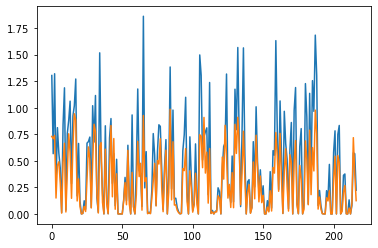

In [22]:
plt.plot(sasa[:, 0])
plt.plot(sasa[:, 1])

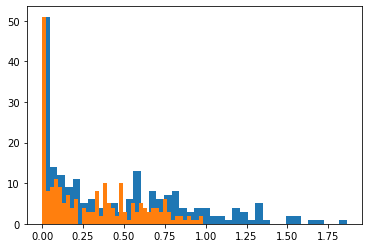

In [23]:
plt.hist(sasa[:, 0], bins=40)
plt.hist(sasa[:, 1], bins=40)

None

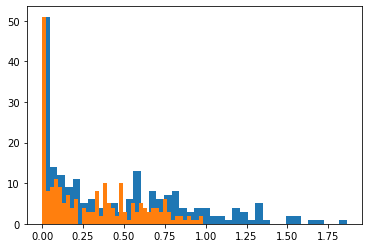

In [24]:
plt.hist(sasa[:, 0], bins=40)
plt.hist(sasa[:, 1], bins=40)

None

In [25]:
sequence_ref_array = np.array(list(sequence_ref))

df["seq_identity"] = list(
    tqdm(
        (
            (sequence_ref_array == np.array(list(sequence))).sum() / len(sequence_ref_array)
            for sequence in df["sequence"]
        ),
        total=len(df),
    )
)

In [26]:
def compute_seq_identity_masked(df, mask):
    sequence_ref_array = np.array(list(sequence_ref))[mask]
    num_true = mask.sum()
    result = list(
        tqdm(
            (
                (sequence_ref_array == np.array(list(sequence))[mask]).sum() / num_true
                for sequence in df["sequence"]
            ),
            total=len(df),
        )
    )
    return result

In [27]:
burried_mask = sasa[:, 1] < 0.2

burried_mask.sum()

104

In [28]:
intermediate_mask = (sasa[:, 1] >= 0.2) & (sasa[:, 1] <= 0.5)

intermediate_mask.sum()

57

In [29]:
exposed_mask = sasa[:, 1] > 0.5

exposed_mask.sum()

56

In [30]:
df["seq_identity_burried"] = compute_seq_identity_masked(df, burried_mask)
df["seq_identity_intermediate"] = compute_seq_identity_masked(df, intermediate_mask)
df["seq_identity_exposed"] = compute_seq_identity_masked(df, exposed_mask)

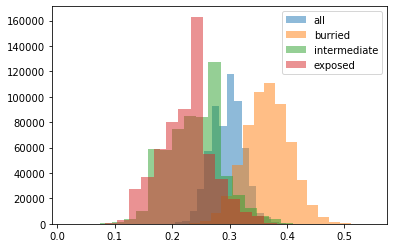

In [31]:
plt.hist(df["seq_identity"], bins=20, alpha=0.5, label="all")
plt.hist(df["seq_identity_burried"], bins=20, alpha=0.5, label="burried")
plt.hist(df["seq_identity_intermediate"], bins=20, alpha=0.5, label="intermediate")
plt.hist(df["seq_identity_exposed"], bins=20, alpha=0.5, label="exposed")
plt.legend()
None

In [32]:
df.head(2)

,sequence,probas_sum,probas_log_sum,seq_identity,seq_identity_burried,seq_identity_intermediate,seq_identity_exposed
0,VEAFTKTIEQFQAQLNGSTRVSSHLFADARSHNLKKLCKVLKEKGV...,74.491379,-327.576019,0.304147,0.413462,0.157895,0.250000
1,IRELDKLIAKYRAELDQRTEISANLKNAGYSRSIREYIPAVKREGI...,66.837112,-389.161255,0.299539,0.413462,0.210526,0.178571


### Save result to single dataframe

In [33]:
pq.write_table(
    pa.Table.from_pandas(df, preserve_index=False),
    NOTEBOOK_PATH.joinpath(f"data-combined-{SEQUENCE_GENERATION_METHOD}-{STRUCTURE_FILE.stem}.parquet"),
    row_group_size=100_000,
)

## Make plots

### Sequence identity

In [34]:
model_stats

{'map_sequence_identity': 0.41013824884792627,
 'map_proba': 0.5304911136627197,
 'map_logproba': -0.6995142102241516,
 'ref_sequence_identity': 1.0,
 'ref_proba': 0.3164460062980652,
 'ref_logproba': -1.7113533020019531}

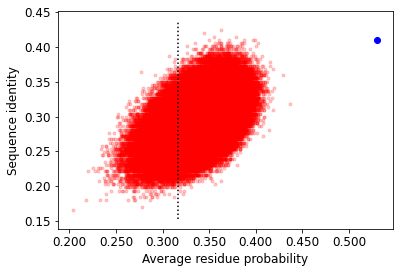

In [35]:
with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    ax.plot(df["probas_sum"] / len(sequence_ref), df["seq_identity"], "r.", alpha=0.2)
    ax.plot(model_stats["map_proba"], model_stats["map_sequence_identity"], "bo")
    ax.vlines(model_stats["ref_proba"], *ax.get_ylim(), linestyles=":", zorder=10)
    ax.set_xlabel("Average residue probability")
    ax.set_ylabel("Sequence identity")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3f}"))

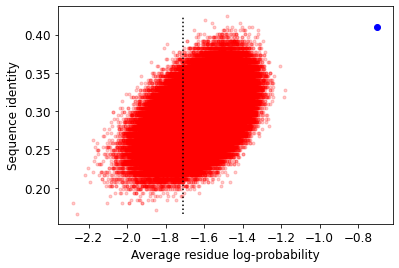

In [36]:
with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots()
    ax.plot(df["probas_log_sum"] / len(sequence_ref), df["seq_identity"], "r.", alpha=0.2)
    ax.plot(model_stats["map_logproba"], model_stats["map_sequence_identity"], "bo")
    ax.vlines(
        model_stats["ref_logproba"], df["seq_identity"].min(), df["seq_identity"].max(), linestyles=":", zorder=10
    )
    ax.set_xlabel("Average residue log-probability")
    ax.set_ylabel("Sequence identity")

### Adjacency matrix

In [37]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
adj = torch_geometric.utils.to_dense_adj(edge_index=data.edge_index, edge_attr=1 / data.edge_attr[:, 0]).squeeze()

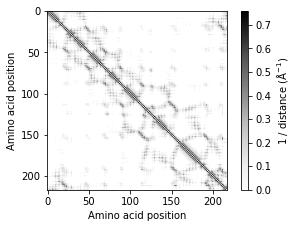

In [38]:
fig = plt.figure(constrained_layout=False, figsize=(4, 3))

gs = fig.add_gridspec(
    nrows=1,
    ncols=2,
    top=0.98,
    right=0.85,
    bottom=0.15,
    left=0.1,
    hspace=0,
    wspace=0,
    width_ratios=[3, 0.1],  # 16
)

ax = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])

out = ax.imshow(adj, cmap="Greys")
ax.set_ylabel("Amino acid position")
ax.set_xlabel("Amino acid position")
ax.tick_params("both")
cb = fig.colorbar(out, cax=cax)
cb.set_label("1 / distance (Å$^{-1}$)")

fig.savefig(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-adjacency.svg"))
fig.savefig(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-adjacency.png"), dpi=300)

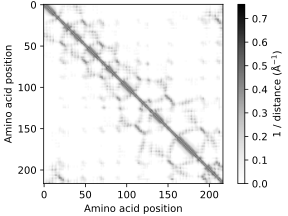

In [39]:
from IPython.display import SVG, Image

display(SVG(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-adjacency.svg")))

### Score distributions

In [40]:
df.head(2)

,sequence,probas_sum,probas_log_sum,seq_identity,seq_identity_burried,seq_identity_intermediate,seq_identity_exposed
0,VEAFTKTIEQFQAQLNGSTRVSSHLFADARSHNLKKLCKVLKEKGV...,74.491379,-327.576019,0.304147,0.413462,0.157895,0.250000
1,IRELDKLIAKYRAELDQRTEISANLKNAGYSRSIREYIPAVKREGI...,66.837112,-389.161255,0.299539,0.413462,0.210526,0.178571


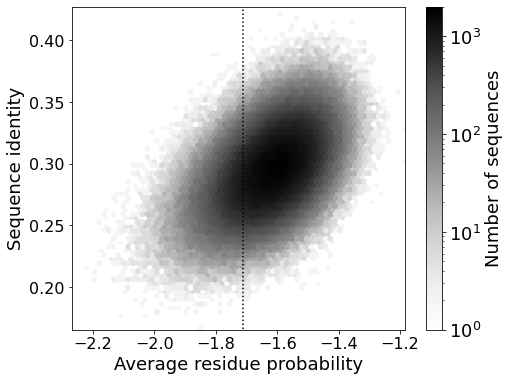

In [41]:
with plt.rc_context(rc={"font.size": 18}):
    fg, ax = plt.subplots(figsize=(8 * 0.9, 6 * 0.9))
    x = df["probas_log_sum"] / len(sequence_ref)
    #     x = np.exp(df["probas_log_sum"] / df["sequence"].str.len())

    #     y = df["seq_identity"].values
    y = df["seq_identity"].values + 0.005 * np.random.randn(len(df))

    nbins = 20
    xlim = np.quantile(x, 0.000001), np.quantile(x, 0.999999)
    ylim = np.quantile(y, 0.000001), np.quantile(y, 0.9999999)

    #     k = kde.gaussian_kde(np.vstack([x, y]))
    #     xi, yi = np.mgrid[xlim[0] : xlim[1] : nbins * 1j, ylim[0] : ylim[1] : nbins * 1j]
    #     zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    #     out = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="Greys")

    #     ax.plot(model_stats["map_proba"], model_stats["map_sequence_identity"], "ro", fillstyle="none")

    out = ax.hexbin(x, y, gridsize=70, bins="log", cmap="Greys")

    ax.vlines(model_stats["ref_logproba"], y.min(), y.max(), linestyles=":", zorder=10)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Sequence identity")
    ax.set_xlabel("Average residue probability")
    ax.tick_params("both", labelsize=16)
    cb = fg.colorbar(out, ax=ax)
    cb.set_label("Number of sequences")

fg.tight_layout()
fg.savefig(
    NOTEBOOK_PATH.joinpath(f"hexbin-{SEQUENCE_GENERATION_METHOD}-{STRUCTURE_FILE.stem}.svg"), bbox_inches="tight"
)

In [42]:
def add_jitter(values):
    return values + 0.008 * np.random.randn(len(df))


def get_xlim(x):
    min_ = x.min()
    max_ = x.max()
    range_ = max_ - min_
    xlim = min_ - range_ * 0.05, max_ + range_ * 0.05
    return xlim


def cmap_color(cmap, alpha):
    cmap = list(plt.get_cmap(cmap, 2)(1))
    return (*cmap[:3], alpha)


def scatter_data(x, y, xlim, ylim, cmap_name, ax):
    color = plt.get_cmap(cmap_name, 4)(2)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    coef = np.polyfit(x, y, 1)
    polyfn = np.poly1d(coef)
    xnew = np.linspace(x.min(), x.max(), 1_000)
    ax.plot(xnew, polyfn(xnew), "-", color=color)

    corr = stats.pearsonr(x, y)[0]
    ax.text(
        0.99,
        0.01,
        f"R² = {corr ** 2:.3f}",
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
    )

    ax.hexbin(
        add_jitter(x),
        y,
        alpha=0.7,
        gridsize=30,
        bins="log",
        cmap=cmap_name,
        extent=(*xlim, *ylim),
        #     vmin=1,
        #     vmax=10_000
    )

In [43]:
df["probas_log_avg"] = df["probas_log_sum"].values / len(sequence_ref)

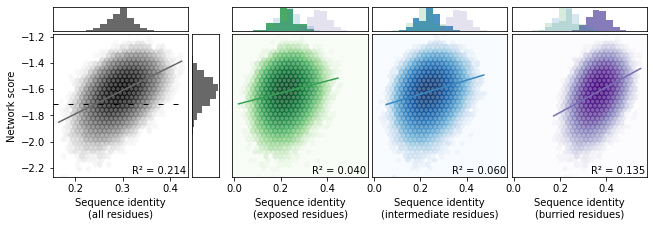

In [44]:
fig = plt.figure(constrained_layout=False, figsize=(9, 3))

gs = fig.add_gridspec(
    nrows=3,
    ncols=7,
    top=0.98,
    right=0.9933,
    bottom=0,
    left=0,
    hspace=0.05,
    wspace=0.05,
    width_ratios=[1, 3, 0.6, 0.1, 3, 3, 3],  # 16
    height_ratios=[1, 6, 1.6],  # 8
)

main_ax = fig.add_subplot(gs[1, 1])
main_top_ax = fig.add_subplot(gs[0, 1])
main_right_ax = fig.add_subplot(gs[1, 2])

side_axs = {
    "seq_identity_exposed": fig.add_subplot(gs[1, 4]),
    "seq_identity_intermediate": fig.add_subplot(gs[1, 5]),
    "seq_identity_burried": fig.add_subplot(gs[1, 6]),
}
side_top_axs = {
    "seq_identity_exposed": fig.add_subplot(gs[0, 4]),
    "seq_identity_intermediate": fig.add_subplot(gs[0, 5]),
    "seq_identity_burried": fig.add_subplot(gs[0, 6]),
}


cmap_name = "Greys"
color = plt.get_cmap(cmap_name, 4)(2)

alpha = 0.7
linestyle = (0, (5, 10))

r = 6
x = df["seq_identity"].values
xlim = x.mean() - r * x.std(), x.mean() + r * x.std()
y = df["probas_log_avg"].values
ylim = y.mean() - r * y.std(), y.mean() + r * y.std()

# xlim = (0.06, 0.54)
# ylim = (-2.7, -1.4)
xlim = get_xlim(x)
ylim = np.quantile(y, 0.000001), np.quantile(y, 0.9999999)

scatter_data(x, y, xlim, ylim, cmap_name, ax=main_ax)
main_ax.set_xlabel("Sequence identity\n(all residues)")
main_ax.set_ylabel("Network score")
main_ax.hlines(model_stats["ref_logproba"], *xlim, linestyles=linestyle, linewidth=1)

main_top_ax.hist(df["seq_identity"].values, color=color, range=xlim, bins=20)
main_top_ax.set_xlim(*xlim)
main_top_ax.set_xticks([])
main_top_ax.set_yticks([])

main_right_ax.hist(
    df["probas_log_sum"].values / len(sequence_ref),
    color=color,
    range=ylim,
    bins=20,
    orientation="horizontal",
)
main_right_ax.set_ylim(*ylim)
main_right_ax.set_xticks([])
main_right_ax.set_yticks([])


sequence_identity_subsets = {
    "seq_identity_exposed": ("exposed", "Greens"),
    "seq_identity_intermediate": ("intermediate", "Blues"),
    "seq_identity_burried": ("burried", "Purples"),
}


xlim = get_xlim(df[list(sequence_identity_subsets)].values.reshape(-1))
# xlim = min(-0.02, x.mean() - 2 * x.std()), x.mean() + 2 * x.std()
# xlim = (-0.02, 0.87)

for column, (column_name, cmap_name) in sequence_identity_subsets.items():
    color = plt.get_cmap(cmap_name, 4)(2)

#     side_axs[column].hlines(model_stats["ref_logproba"], *xlim, linestyles=linestyle, linewidth=1)
    scatter_data(df[column].values, y, xlim, ylim, cmap_name, ax=side_axs[column])
    side_axs[column].set_yticks([])
    side_axs[column].set_xlabel(f"Sequence identity\n({column_name} residues)")

    side_top_axs[column].hist(df[column].values, color=color, alpha=0.9, range=xlim, bins=20)
    for column_other, (_, cmap_name_other) in sequence_identity_subsets.items():
        if column_other == column:
            continue
        color_other = plt.get_cmap(cmap_name_other, 4)(2)
        side_top_axs[column].hist(
            df[column_other].values, color=color_other, alpha=0.2, range=xlim, bins=20
        )
    side_top_axs[column].set_xlim(*xlim)
    side_top_axs[column].set_xticks([])
    side_top_axs[column].set_yticks([])

fig.savefig(NOTEBOOK_PATH.joinpath(f"sequence-identity-vs-proba-{STRUCTURE_FILE.stem}.pdf"))
fig.savefig(NOTEBOOK_PATH.joinpath(f"sequence-identity-vs-proba-{STRUCTURE_FILE.stem}.svg"))
fig.savefig(
    NOTEBOOK_PATH.joinpath(f"sequence-identity-vs-proba-{STRUCTURE_FILE.stem}.png"), dpi=300
)

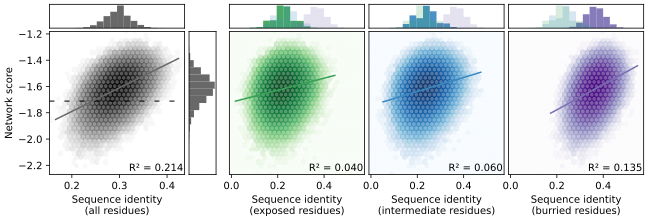

In [45]:
from IPython.display import SVG, Image

display(SVG(NOTEBOOK_PATH.joinpath(f"sequence-identity-vs-proba-{STRUCTURE_FILE.stem}.svg")))

In [46]:
raise Exception

Exception: 

### Sequence logo

In [ ]:
stacks_per_line = 110

In [ ]:
for i in range(0, len(sequence_ref), stacks_per_line):
    svg_file_wt = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-wt-{i}.svg")

    kmtools.sci_tools.make_weblogo(
        [sequence_ref[i : i + stacks_per_line]],
        units="probability",
        color_scheme="hydrophobicity",
        stacks_per_line=stacks_per_line,
        format="svg",
        aspect_ratio=1,
        show_xaxis=False,
        show_yaxis=False,
        errorbars=False,
        ylabel="",
        fineprint="",
        output_file=svg_file_wt,
    )

In [ ]:
xxx = df[(df["probas_sum"] > 0.15 * len(sequence_ref)) & (df["seq_identity"] < 0.15)]

for i in range(0, len(sequence_ref), stacks_per_line):
    svg_file_gen = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-gen-{i}.svg")

    kmtools.sci_tools.make_weblogo(
        df["sequence"].str[i : i + stacks_per_line].values,
        units="bits",
        color_scheme="hydrophobicity",
        stacks_per_line=stacks_per_line,
        format="svg",
        aspect_ratio=5,
        #     show_xaxis=False,
        #     show_yaxis=False,
        errorbars=False,
        #     ylabel="",
        fineprint="",
        output_file=svg_file_gen,
        annotate=",".join(
            (str(n + 1) if (n + 1) % 5 == 0 else "") for n in range(i, min(len(sequence_ref), i + stacks_per_line))
        ),
        number_interval=5,
    )

In [ ]:
def process_svg(file_in, file_out):
    ET.register_namespace("", "http://www.w3.org/2000/svg")
    tree = ET.parse(file_in)
    root = tree.getroot()

    width = root.attrib.pop("width", "").strip("pt")
    height = root.attrib.pop("height", "").strip("pt")
    _, _, width_vb, height_vb = root.attrib["viewBox"].split(" ")
    assert not width or width == width_vb, (width, width_vb)
    assert not height or height == height_vb, (height, height_vb)

    root.attrib["preserveAspectRatio"] = "none"
    tree.write(file_out)

    return width_vb, height_vb

In [ ]:
def generate_inner_div(svg_file_wt, svg_file_gen, scale=1, relative_to=Path.cwd()):
    html_doc = f"""\
        <div>
        <img src="{svg_file_wt.relative_to(relative_to)}" style="display: block; margin-left: auto; margin-bottom: -0.9%; width: {scale:%}" />
        <img src="{svg_file_gen.relative_to(relative_to)}" style="display: block; width: 100%" />
        </div>
        """
    return html_doc

In [ ]:
def combine_wt_and_gen(svg_file_wt, svg_file_gen, output_file_stem):
    with tempfile.TemporaryDirectory() as temp_dir:
        width_wt, height_wt = process_svg(svg_file_wt, Path(temp_dir, svg_file_wt.name))
        width_gen, height_gen = process_svg(svg_file_gen, Path(temp_dir, svg_file_gen.name))

        inner_div = generate_inner_div(
            Path(temp_dir, svg_file_wt.name),
            Path(temp_dir, svg_file_gen.name),
            scale=float(width_wt) / float(width_gen),
            relative_to=temp_dir,
        )

        html_doc = dedent(
            f"""\
            <!DOCTYPE html>
            <html>

            <head>
              <meta charset="utf-8">
              <title></title>
              <meta name="author" content="">
              <meta name="description" content="">
              <meta name="viewport" content="width=device-width, initial-scale=1">
                <style>
                @media print {{
                    @page {{ size: {width_gen}px {int(height_gen) + 14}px; margin: 0; }}
                    html, body {{ margin: 0; }}
                }}
                </style>
            </head>

            <body>

            {inner_div}

            </body>

            </html>
            """
        )

        html_file = Path(temp_dir, "output.html")
        with html_file.open("wt") as fout:
            fout.write(html_doc)

        pdf_file = Path(temp_dir, "output.pdf")
        system_command = f'{Path("~/opt/chrome-linux/chrome").expanduser()} --headless --disable-gpu --print-to-pdf "{html_file}"'
        cp = subprocess.run(shlex.split(system_command), cwd=temp_dir, check=True)

        svg_file = pdf_file.with_suffix(".svg")
        system_command = f'pdf2svg "{pdf_file}" "{svg_file}"'
        cp = subprocess.run(shlex.split(system_command), cwd=temp_dir, check=True)
        assert svg_file.is_file()

        shutil.copy2(pdf_file, output_file_stem.with_suffix(".pdf"))
        shutil.copy2(svg_file, output_file_stem.with_suffix(".svg"))

In [ ]:
for i in range(0, len(sequence_ref), stacks_per_line):
    svg_file_wt = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-wt-{i}.svg")
    svg_file_gen = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-gen-{i}.svg")
    svg_file = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-{i}.svg")

    combine_wt_and_gen(svg_file_wt, svg_file_gen, svg_file)
    display(SVG(svg_file))

In [ ]:
# !wget https://storage.googleapis.com/chromium-browser-snapshots/Linux_x64/706915/chrome-linux.zip -P /tmp

In [ ]:
# !./chrome-linux/chrome --headless --disable-gpu --print-to-pdf deleteme.html

In [ ]:
# !pdf2svg output.pdf output.svg